In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend('sox_io')
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import psutil

from utils import *
from datasets import *
from models import *
from profiler import WingbeatDatasetProfiler

Available workers: 16


# Cleaning Settings

In [3]:
maxpeaks = 15
minpeaks = 1
maxscore = 15
minscore = 2.5
minduration = 100
selection = f"peaks>={minpeaks} & peaks<={maxpeaks} & score>{minscore} & score<={maxscore} & duration>={minduration}"

# Dataset SD

In [21]:
dataset_sd = WingbeatDatasetProfiler(dsname="/home/kalfasyan/data/wingbeats/Fruitflies_flytrap_rpi/from_sd/Melanogaster/", bandpass_low=140., bandpass_high=1500., rpiformat=False, custom_label=[0])

Found 21129 in dataset: /home/kalfasyan/data/wingbeats/Fruitflies_flytrap_rpi/from_sd/Melanogaster/, and 1 label(s): ['from_sd']
Label(s) changed to [0]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Duration..
Sum..
Max..
Bad chunk score
Filename..
Date..
Date string..
Datehour string..
Finished.


# Dataset RPi

In [5]:
dataset_rpi = WingbeatDatasetProfiler(dsname="/home/kalfasyan/data/wingbeats/Fruitflies_flytrap_rpi/from_rpi/Melanogaster//", bandpass_low=140., bandpass_high=1500., rpiformat=True, custom_label=[0])

Found 436 in dataset: /home/kalfasyan/data/wingbeats/Fruitflies_flytrap_rpi/from_rpi/Melanogaster//, and 1 label(s): ['from_rpi']
Label(s) changed to [0]


  warnings.warn('nperseg = {0:d} is greater than input length '
/home/kalfasyan/anaconda3/envs/wbai/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 5000 is greater than input length  = 4667, using nperseg = 4667
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/kalfasyan/anaconda3/envs/wbai/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 5000 is greater than input length  = 4667, using nperseg = 4667
  warnings.warn('nperseg = {0:d} is greater than input length '


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Duration..
Sum..
Max..
Bad chunk score
Filename..
Date..
Date string..
Datehour string..
Finished.


# Comparison

In [6]:
df_rpi = dataset_rpi.df.query(selection)
print('rpi')
print(df_rpi.shape)
df_sd = dataset_sd.df.query(selection)
print('sd')
print(df_sd.shape)
df_sd = df_sd.sample(df_rpi.shape[0])
print('downsampling')
print(df_sd.shape)

rpi
(346, 14)
sd
(12509, 14)
downsampling
(346, 14)


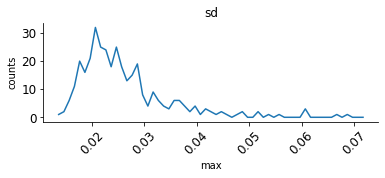

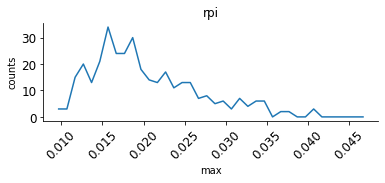

In [7]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_sd, 'max', res=0.001)
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_rpi, 'max', res=0.001)

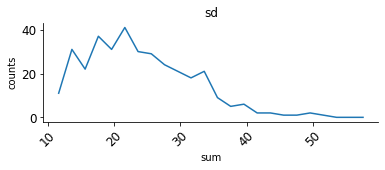

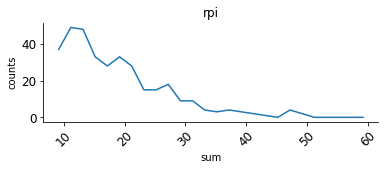

In [8]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_sd, 'sum', res=2, )
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_rpi, 'sum', res=2)

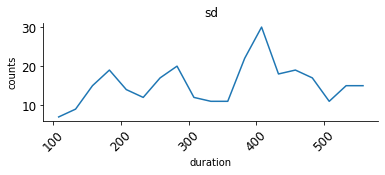

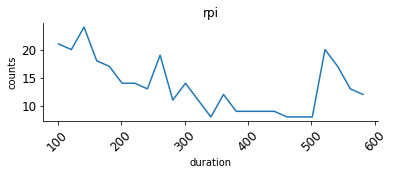

In [9]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_sd, 'duration', res=25, )
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_rpi, 'duration', res=20)

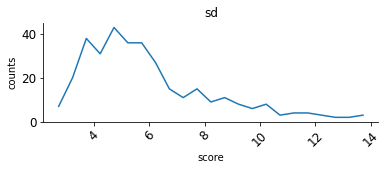

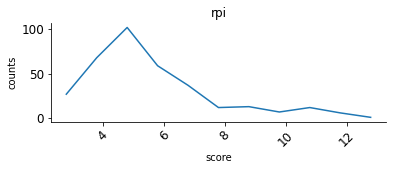

In [10]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_sd, 'score', res=0.5, )
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_rpi, 'score', res=1)

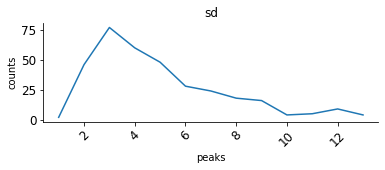

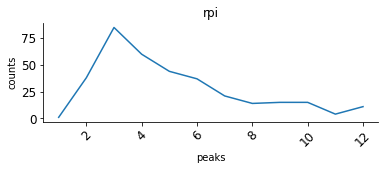

In [11]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_sd, 'peaks', res=1, )
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_rpi, 'peaks', res=1)

# Bad Chunk Score

## How BCS was made

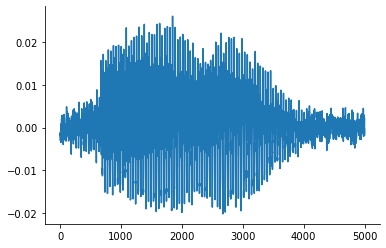

PartA score: 1.6172857001303165
PartB score: 4.660602462970342
PartB score - PartA score : 3.0433167628400257


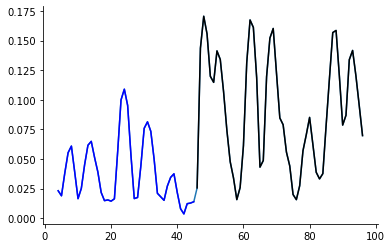

In [12]:
n = np.random.randint(0, len(df_rpi))

open_wingbeat(df_rpi.x.iloc[n], plot=True)
sig = open_wingbeat(df_rpi.x.iloc[n]).squeeze().numpy()
sig = scale(sig)

part = sig[620:712+5]
part = pd.Series(part).rolling(5).std().abs()
part.plot()

partA = part.iloc[:46]
partB = part.iloc[46:]
# plt.figure()
partA.plot(color='b')
partB.plot(color='k')

scoreA = partA.sum()
scoreB = partB.sum()

score = scoreB - scoreA

print(f"PartA score: {scoreA}\nPartB score: {scoreB}")
print(f"PartB score - PartA score : {score}")

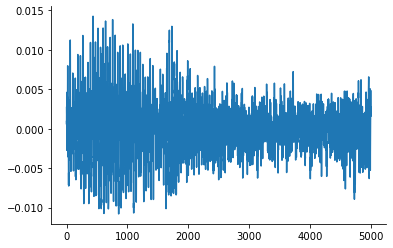

0.6692714122005725

In [13]:
n = np.random.randint(0, len(df_rpi))
open_wingbeat(df_rpi.x.iloc[n], plot=True)
sig = open_wingbeat(df_rpi.x.iloc[n]).squeeze().numpy()

get_bad_first_chunk_score(sig)

## Examples

 35%|███▌      | 7/20 [00:00<00:00, 64.98it/s]

251 out of 346


100%|██████████| 20/20 [00:00<00:00, 71.80it/s]


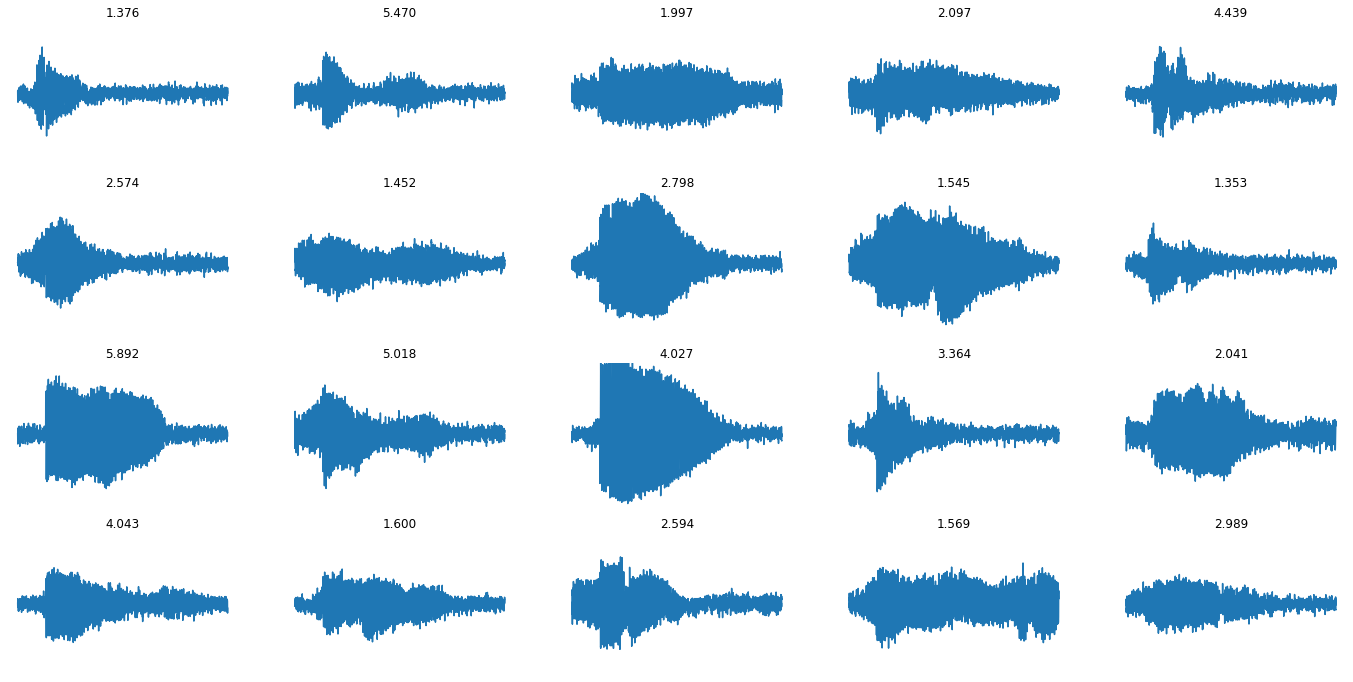

In [14]:
bcs = 1.3

df = df_rpi[df_rpi.badchunkscore>bcs]
print(f"{df.shape[0]} out of {df_rpi.shape[0]}")

plt.figure(figsize=(24,12))
for i in tqdm(range(20)):
    plt.subplot(4,5,i+1)
    plt.plot(open_wingbeat(df.x.iloc[i]).squeeze().numpy())
    plt.ylim(-.03,.03)
    plt.axis('off')
    plt.title(f"{df.badchunkscore.iloc[i]:.3f}")

In [15]:
df_rpi[df_rpi.badchunkscore>=.8].shape


(297, 14)

In [16]:
df_rpi.shape

(346, 14)

# Using DrosophilaNet

In [17]:
name = 'drosophilatime' # 'inception' # 'drosophilatime'
outs = 1 # you can set this to 1 if you want to use binary CE loss instead of CrossEntropy
num_epochs = 35
modeltype = f'{name}_outs{outs}_epochs{num_epochs}' #'inception'
pretrained_modelname = f"model_{modeltype}_best"
batch_size = 32
batch_size_val = 32
num_workers = 10
dropout_rate = .2
valsplit_pct = .2 # 0.13
random_seed= 42

model = DrosophilaNetTIME(outputs=outs, dropout_p=dropout_rate)

optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
model = load_checkpoint(f"../data_created/{pretrained_modelname}.pth.tar", model, optimizer)[0]
model = model.to('cuda', dtype=torch.float)
model.eval();

In [18]:
from transforms import *
transforms_list_test = [Bandpass(lowcut=140, highcut=1500)]

rpi_dataset = DataFrameset(df_rpi, transform=transforms.Compose(transforms_list_test))
rpi_dataloader = DataLoader(rpi_dataset, batch_size=batch_size_val, shuffle=False)

1

In [23]:
preds = []
preds_raw = []
for n in tqdm(range(len(df_rpi))):
    sig = open_wingbeat(df_rpi.x.iloc[n]).cuda()
    out = model(sig.unsqueeze(0))
    preds_raw.append(out.cpu().detach().numpy()[0,0])
    preds.append(int(out >= 0.8))

df_rpi['rawpred'] = preds_raw
df_rpi['preds'] = preds
df_rpi.preds.value_counts()

100%|██████████| 346/346 [00:00<00:00, 494.03it/s]
<ipython-input-23-68fd4cc5bc04>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rpi['rawpred'] = preds_raw
<ipython-input-23-68fd4cc5bc04>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rpi['preds'] = preds


0    185
1    161
Name: preds, dtype: int64

In [39]:
preds = []
preds_raw = []
for n in tqdm(range(len(df_rpi))):
    sig = open_wingbeat(df_rpi.x.iloc[n]).cuda()
    out = model(sig.unsqueeze(0))
    preds_raw.append(out.cpu().detach().numpy()[0,0])
    preds.append(int(out >= 0.8))

df_rpi['rawpred'] = preds_raw
df_rpi['preds'] = preds
df_rpi.preds.value_counts()

100%|██████████| 106/106 [00:00<00:00, 381.64it/s]
<ipython-input-39-68fd4cc5bc04>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rpi['rawpred'] = preds_raw
<ipython-input-39-68fd4cc5bc04>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rpi['preds'] = preds


1    85
0    21
Name: preds, dtype: int64

In [20]:
preds = []
preds_raw = []
for n in tqdm(range(len(df_sd))):
    sig = open_wingbeat(df_sd.x.iloc[n]).cuda()
    out = model(sig.unsqueeze(0))
    preds_raw.append(out.cpu().detach().numpy()[0,0])
    preds.append(int(out >= 0.8))

df_sd['rawpred'] = preds_raw
df_sd['preds'] = preds
df_sd.preds.value_counts()

100%|██████████| 346/346 [00:00<00:00, 509.87it/s]


0    278
1     68
Name: preds, dtype: int64

In [38]:
preds = []
preds_raw = []
for n in tqdm(range(len(df_sd))):
    sig = open_wingbeat(df_sd.x.iloc[n]).cuda()
    out = model(sig.unsqueeze(0))
    preds_raw.append(out.cpu().detach().numpy()[0,0])
    preds.append(int(out >= 0.8))

df_sd['rawpred'] = preds_raw
df_sd['preds'] = preds
df_sd.preds.value_counts()

100%|██████████| 106/106 [00:00<00:00, 415.14it/s]


0    78
1    28
Name: preds, dtype: int64

# Hist of BCS when wrong

<AxesSubplot:>

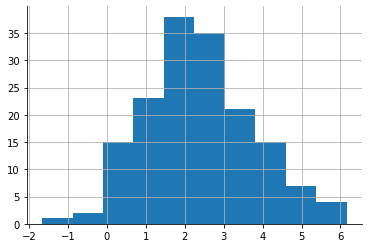

In [29]:
df_rpi[df_rpi.preds==1].badchunkscore.hist()

## Hist of BCS when right

<AxesSubplot:>

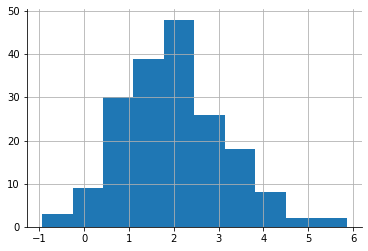

In [30]:
df_rpi[df_rpi.preds==0].badchunkscore.hist()